In [ ]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import softmax
import multiprocessing as mp
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.nn import functional as F
from sklearn.preprocessing import normalize

# Installing ProdLDA
**Restart notbook after the installation!!**

In [ ]:
!git clone https://github.com/estebandito22/PyTorchAVITM

Cloning into 'PyTorchAVITM'...
remote: Enumerating objects: 19052, done.
remote: Total 19052 (delta 0), reused 0 (delta 0), pack-reused 19052
Receiving objects: 100% (19052/19052), 132.62 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (37/37), done.


# 1. Creation of synthetic corpus

We consider a scenario with n parties, each of them as an associated corpus.
To generate the corpus associated with each of the parties, we consider a common beta distribution (word-topic distribution), but we freeze different topics/ assign different asymmetric Dirichlet priors favoring different topics at the time of generating the document that composes each party's corpus.

## 1.1. Function for permuting the Dirichlet prior at each node

In [ ]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

## 1.2. Topic modeling and node settings

In [ ]:
# Topic modeling settings
vocab_size = 1000
n_topics = 10
beta = 10
alpha = 5/n_topics
n_docs = 1000
nwords = (150, 450) #Min and max lengths of the documents

# Nodes settings
n_nodes = 5
frozen_topics = 3
dirichlet_symmetric = False
prior = (n_topics)*[0.9]
prior[0] = prior[1] = prior[2] = 0.1
print(prior)

[0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]


## 1.3. Topics generation (common for all nodes)

In [ ]:
topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
print('Ordered probabilities for the first topic vector:')
print(np.sort(topic_vectors[0])[::-1])
print(topic_vectors.shape)

Ordered probabilities for the first topic vector:
[0.00216189 0.00209201 0.00204932 0.00202167 0.00197597 0.00192813
 0.00192633 0.00192144 0.00191688 0.00191116 0.00188827 0.00188267
 0.00186135 0.00182845 0.00181846 0.00181357 0.00181267 0.00177286
 0.00176281 0.00175662 0.00174947 0.00174723 0.00174637 0.00174494
 0.00173748 0.00173353 0.00173063 0.00172758 0.00172637 0.0017228
 0.00171088 0.00170778 0.00169424 0.00167567 0.00167456 0.00166255
 0.0016607  0.00165041 0.00164919 0.00163921 0.00163234 0.00162723
 0.00162349 0.00161775 0.00161035 0.0016056  0.00159488 0.00159442
 0.00159346 0.00159024 0.00158832 0.00158095 0.00158079 0.00157692
 0.00157684 0.00157102 0.00156955 0.00156502 0.00155915 0.00155645
 0.00155644 0.00155469 0.00155346 0.00155066 0.0015496  0.0015492
 0.00154728 0.00154612 0.00154494 0.00154494 0.00154313 0.00154211
 0.00153775 0.00153735 0.00152927 0.00152825 0.00152511 0.00152151
 0.00151956 0.00151335 0.00151249 0.00151209 0.00150786 0.00149348
 0.00148925 0.

## 1.4. Generation of document topic proportions and documents for each node


In [ ]:
doc_topics_all_gt = []
documents_all = []
z_all = []
for i in np.arange(n_nodes):
  # Step 2 - generation of document topic proportions for each node
  if dirichlet_symmetric:
    doc_topics = np.random.dirichlet((n_topics)*[alpha], n_docs)
  else:
    doc_topics = np.random.dirichlet(prior, n_docs)
    prior = rotateArray(prior, len(prior), 3)
    print(prior)
  print('Ordered probabilities for the first document - node', str(i), ':')
  print(np.sort(doc_topics[0])[::-1])
  doc_topics_all_gt.append(doc_topics)
  # Step 3 - Document generation
  documents = [] # Document words
  z = [] # Assignments
  for docid in np.arange(n_docs):
      doc_len = np.random.randint(low=nwords[0], high=nwords[1])
      this_doc_words = []
      this_doc_assigns = []
      for wd_idx in np.arange(doc_len):
          tpc = np.nonzero(np.random.multinomial(1, doc_topics[docid]))[0][0]
          this_doc_assigns.append(tpc)
          word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
          this_doc_words.append('wd'+str(word))
      z.append(this_doc_assigns)
      documents.append(this_doc_words)
  print("Documents of node", str(i), "generated.")
  documents_all.append(documents)
  z_all.append(z)

[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1]
Ordered probabilities for the first document - node 0 :
[4.63289165e-01 1.86301245e-01 1.15191386e-01 1.02139123e-01
 7.10482506e-02 3.34788042e-02 2.30668751e-02 3.32753731e-03
 2.15394623e-03 3.66883020e-06]
Documents of node 0 generated.
[0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9]
Ordered probabilities for the first document - node 1 :
[2.87208720e-01 2.56446226e-01 2.46110799e-01 9.30152947e-02
 7.87984547e-02 2.00520730e-02 1.83357838e-02 3.26083535e-05
 2.47902792e-08 1.67972926e-08]
Documents of node 1 generated.
[0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
Ordered probabilities for the first document - node 2 :
[2.78356097e-01 2.59269241e-01 2.05918280e-01 1.83367558e-01
 3.07875527e-02 2.89320117e-02 7.75748134e-03 5.52707790e-03
 8.46370007e-05 6.28150618e-08]
Documents of node 2 generated.
[0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1]
Ordered probabilities for the first document - node 3 :
[3.86126814e-01 2

# 2. Preprocessing, generation of training dataset and training of a ProdLDA model at each node

In [ ]:
ls

call_signature.png  LICENSE.md  pytorchavitm/  README.md  train_abs.py
data/               outputs/    PyTorchAVITM/  setup.py   train.py


In [ ]:
cd /content/PyTorchAVITM/pytorchavitm/datasets

/content/PyTorchAVITM/pytorchavitm/datasets


In [ ]:
from bow import BOWDataset

In [ ]:
cd /content/PyTorchAVITM

/content/PyTorchAVITM


In [ ]:
from pytorchavitm import AVITM

In [ ]:
train_datasets = []
avitms = []
id2tokens = []
for corpus_node in documents_all:
  cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
  docs = [" ".join(corpus_node[i]) for i in np.arange(len(corpus_node))]

  train_bow = cv.fit_transform(docs)
  train_bow = train_bow.toarray()

  idx2token = cv.get_feature_names()
  input_size = len(idx2token)

  id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
  id2tokens.append(id2token)

  train_data = BOWDataset(train_bow, idx2token)

  avitm = AVITM(input_size=input_size, n_components=10, model_type='prodLDA',
                hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
                learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
                solver='adam', num_epochs=100, reduce_on_plateau=False)

  avitm.fit(train_data)
  avitms.append(avitm)

  train_datasets.append(train_data)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [1000/100000]	Train Loss: 2232.401390625	Time: 0:00:00.203384
Epoch: [2/100]	Samples: [2000/100000]	Train Loss: 2214.83128125	Time: 0:00:00.211200
Epoch: [3/100]	Samples: [3000/100000]	Train Loss: 2206.3879609375	Time: 0:00:00.249124
Epoch: [4/100]	Samples: [4000/100000]	Train Loss: 2198.043171875	Time: 0:00:00.217579
Epoch: [5/100]	Samples: [5000/100000]	Train Loss: 2193.7402265625	Time: 0:00:00.226681
Epoch: [6/100]	Samples: [6000/100000]	Train Loss: 2188.174109375	Time: 0:00:00.219552
Epoch: [7/100]	Samples: [7000/100000]	Train Loss: 2182.423015625	Time: 0:00:00.198638
Epoch: [8/100]	Samples: [8000/100000]	Train Loss: 2177.3878828125	Time: 0:00:00.203180
Epoch: [9/100]	Samples: [9000/100000]	Train Loss: 2171.9964921875	Time: 0:00:00.207316
Epoch: [10/100]	Samples: [10000/100000]	Train Loss: 2166.787359375	Time: 0:00:00.218218
Epoch: [11/100]	Samples: [11000/100000]	Train Loss: 2161.0753671875	Time: 0:00:00.213121
Epoch: [12/100]	Samples: [12000/100000]	Train 

# 2.1 Topics at each node

In [ ]:
topics_all = []
for node in np.arange(n_nodes):
  topics = pd.DataFrame(avitm.get_topics(10)).T
  topics_all.append(topics)
topics_all[0]

,0,1,2,3,4,5,6,7,8,9
0,wd594,wd72,wd881,wd321,wd817,wd221,wd666,wd993,wd86,wd756
1,wd321,wd50,wd895,wd993,wd888,wd767,wd0,wd397,wd931,wd234
2,wd355,wd705,wd330,wd368,wd952,wd666,wd474,wd698,wd635,wd797
3,wd446,wd720,wd374,wd518,wd103,wd881,wd386,wd871,wd467,wd195
4,wd163,wd986,wd787,wd123,wd406,wd588,wd579,wd247,wd145,wd521
5,wd986,wd48,wd766,wd652,wd787,wd380,wd37,wd549,wd937,wd203
6,wd813,wd66,wd174,wd588,wd163,wd570,wd787,wd722,wd759,wd91
7,wd684,wd270,wd63,wd394,wd934,wd596,wd227,wd636,wd590,wd458
8,wd369,wd311,wd696,wd546,wd892,wd248,wd606,wd542,wd127,wd372
9,wd621,wd174,wd588,wd890,wd907,wd10,wd787,wd48,wd660,wd163


## 2.2 Document-topic distributions at each node

In [ ]:
def get_doc_topic_distribution(avitm, dataset, n_samples=20):
    avitm.model.eval()

    loader = DataLoader(
            avitm.train_data, batch_size=avitm.batch_size, shuffle=True,
            num_workers=mp.cpu_count())

    pbar = tqdm(n_samples, position=0, leave=True)

    final_thetas = []
    for sample_index in range(n_samples):
        with torch.no_grad():
            collect_theta = []

            for batch_samples in loader:
                X = batch_samples['X']

                if avitm.USE_CUDA:
                  X = X.cuda()

                # forward pass
                avitm.model.zero_grad()
                
                with torch.no_grad():
                  posterior_mu, posterior_log_sigma = avitm.model.inf_net(X)

                  # Generate samples from theta
                  theta = F.softmax(
                          avitm.model.reparameterize(posterior_mu, posterior_log_sigma), dim=1)
                  theta = avitm.model.drop_theta(theta)

                collect_theta.extend(theta.cpu().numpy().tolist())

            pbar.update(1)
            pbar.set_description("Sampling: [{}/{}]".format(sample_index + 1, n_samples))

            final_thetas.append(np.array(collect_theta))
    pbar.close()
    return np.sum(final_thetas, axis=0) / n_samples

In [ ]:
doc_topic_all = []
for node in np.arange(n_nodes):
  doc_topic = get_doc_topic_distribution(avitms[node], train_datasets[node], n_samples=5) # get all the topic predictions
  print("Document-topic distribution node", str(node), "")
  doc_topic_all.append(doc_topic)
  print(np.array(doc_topics).shape)

Sampling: [5/5]: : 5it [00:00,  5.96it/s]


Document-topic distribution node 0 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.12it/s]


Document-topic distribution node 1 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.18it/s]


Document-topic distribution node 2 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.10it/s]


Document-topic distribution node 3 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  5.99it/s]


Document-topic distribution node 4 
(1000, 10)


## 2.3 Word-topic distributions attained at each node

In [ ]:
def get_topic_word_distribution(avtim_model):
  topic_word_matrix = avtim_model.model.beta.cpu().detach().numpy()
  return softmax(topic_word_matrix, axis=1)

In [ ]:
all_words = []
for word in np.arange(vocab_size+1):
  if word > 0:
    all_words.append('wd'+str(word))
print(all_words)

['wd1', 'wd2', 'wd3', 'wd4', 'wd5', 'wd6', 'wd7', 'wd8', 'wd9', 'wd10', 'wd11', 'wd12', 'wd13', 'wd14', 'wd15', 'wd16', 'wd17', 'wd18', 'wd19', 'wd20', 'wd21', 'wd22', 'wd23', 'wd24', 'wd25', 'wd26', 'wd27', 'wd28', 'wd29', 'wd30', 'wd31', 'wd32', 'wd33', 'wd34', 'wd35', 'wd36', 'wd37', 'wd38', 'wd39', 'wd40', 'wd41', 'wd42', 'wd43', 'wd44', 'wd45', 'wd46', 'wd47', 'wd48', 'wd49', 'wd50', 'wd51', 'wd52', 'wd53', 'wd54', 'wd55', 'wd56', 'wd57', 'wd58', 'wd59', 'wd60', 'wd61', 'wd62', 'wd63', 'wd64', 'wd65', 'wd66', 'wd67', 'wd68', 'wd69', 'wd70', 'wd71', 'wd72', 'wd73', 'wd74', 'wd75', 'wd76', 'wd77', 'wd78', 'wd79', 'wd80', 'wd81', 'wd82', 'wd83', 'wd84', 'wd85', 'wd86', 'wd87', 'wd88', 'wd89', 'wd90', 'wd91', 'wd92', 'wd93', 'wd94', 'wd95', 'wd96', 'wd97', 'wd98', 'wd99', 'wd100', 'wd101', 'wd102', 'wd103', 'wd104', 'wd105', 'wd106', 'wd107', 'wd108', 'wd109', 'wd110', 'wd111', 'wd112', 'wd113', 'wd114', 'wd115', 'wd116', 'wd117', 'wd118', 'wd119', 'wd120', 'wd121', 'wd122', 'wd123', 

In [ ]:
topic_word_all = []
for node in np.arange(n_nodes):
  w_t_distrib = np.zeros((10,vocab_size), dtype=np.float64) 
  wd = get_topic_word_distribution(avitms[node])
  for i in np.arange(10):
    for idx, word in id2tokens[node].items():
      for j in np.arange(len(all_words)):
        if all_words[j] == word:
          w_t_distrib[i,j] = wd[i][idx]
          break
  sum_of_rows = w_t_distrib.sum(axis=1)
  normalized_array = w_t_distrib / sum_of_rows[:, np.newaxis]
  topic_word_all.append(normalized_array)

# 3. Centralized model

In [ ]:
documents_centr = [*documents_all[0], *documents_all[1], *documents_all[2], *documents_all[3], *documents_all[4]]
len(documents_centr)

5000

In [ ]:
cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
docs_centr = [" ".join(documents_centr[i]) for i in np.arange(len(documents_centr))]

train_bow_centr = cv.fit_transform(docs_centr)
train_bow_centr = train_bow_centr.toarray()

idx2token_centr = cv.get_feature_names()
input_size_centr = len(idx2token_centr)

id2token_centr = {k: v for k, v in zip(range(0, len(idx2token_centr)), idx2token_centr)}

train_data_centr = BOWDataset(train_bow_centr, idx2token_centr)

avitm_centr = AVITM(input_size=input_size_centr, n_components=10, model_type='prodLDA',
              hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
              learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
              solver='adam', num_epochs=100, reduce_on_plateau=False)

avitm_centr.fit(train_data_centr)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [5000/500000]	Train Loss: 2183.912605078125	Time: 0:00:00.692837
Epoch: [2/100]	Samples: [10000/500000]	Train Loss: 2157.90883671875	Time: 0:00:00.653632
Epoch: [3/100]	Samples: [15000/500000]	Train Loss: 2136.135812109375	Time: 0:00:00.659005
Epoch: [4/100]	Samples: [20000/500000]	Train Loss: 2112.539268359375	Time: 0:00:00.668727
Epoch: [5/100]	Samples: [25000/500000]	Train Loss: 2094.055711328125	Time: 0:00:00.628219
Epoch: [6/100]	Samples: [30000/500000]	Train Loss: 2084.238319921875	Time: 0:00:00.680411
Epoch: [7/100]	Samples: [35000/500000]	Train Loss: 2080.6717609375	Time: 0:00:00.684884
Epoch: [8/100]	Samples: [40000/500000]	Train Loss: 2079.126473046875	Time: 0:00:00.678835
Epoch: [9/100]	Samples: [45000/500000]	Train Loss: 2078.6507619140625	Time: 0:00:00.672240
Epoch: [10/100]	Samples: [50000/500000]	Train Loss: 2078.347369140625	Time: 0:00:00.683641
Epoch: [11/100]	Samples: [55000/500000]	Train Loss: 2078.021916015625	Time: 0:00:00.650029
Epoch: [12/

In [ ]:
topics_centr = pd.DataFrame(avitm_centr.get_topics(10)).T
topics_centr

,0,1,2,3,4,5,6,7,8,9
0,wd356,wd298,wd292,wd556,wd411,wd227,wd738,wd471,wd648,wd162
1,wd173,wd82,wd477,wd795,wd99,wd434,wd486,wd399,wd911,wd790
2,wd4,wd589,wd92,wd369,wd685,wd790,wd98,wd909,wd374,wd748
3,wd175,wd355,wd788,wd553,wd571,wd260,wd816,wd728,wd533,wd492
4,wd389,wd772,wd748,wd101,wd553,wd368,wd355,wd445,wd567,wd856
5,wd912,wd21,wd592,wd185,wd221,wd643,wd80,wd599,wd94,wd278
6,wd966,wd952,wd541,wd584,wd81,wd818,wd165,wd773,wd412,wd266
7,wd905,wd119,wd614,wd80,wd319,wd50,wd289,wd718,wd774,wd474
8,wd131,wd601,wd892,wd574,wd448,wd301,wd635,wd752,wd576,wd590
9,wd705,wd806,wd265,wd231,wd752,wd314,wd719,wd894,wd545,wd290


In [ ]:
doc_topic_centr = get_doc_topic_distribution(avitm_centr, train_data_centr, n_samples=5) # get all the topic predictions
print(doc_topic_centr.shape)

Sampling: [5/5]: : 5it [00:01,  2.62it/s]

(5000, 10)


In [ ]:
w_t_distrib_centr = np.zeros((10,vocab_size), dtype=np.float64) # vocab_size = 10000
wd = get_topic_word_distribution(avitm_centr)
for i in np.arange(10):
  for idx, word in id2token_centr.items():
    for j in np.arange(len(all_words)):
      if all_words[j] == word:
        w_t_distrib_centr[i,j] = wd[i][idx]
        break
sum_of_rows = w_t_distrib_centr.sum(axis=1)
w_t_distrib_centr_norm = w_t_distrib_centr / sum_of_rows[:, np.newaxis]
print(w_t_distrib_centr_norm)
sum(w_t_distrib_centr_norm[8,:])

[[0.00102535 0.00095503 0.00101596 ... 0.00098853 0.00100016 0.        ]
 [0.00100684 0.00094763 0.00101549 ... 0.00101879 0.00101515 0.        ]
 [0.00097415 0.00103656 0.00098535 ... 0.00103208 0.00099289 0.        ]
 ...
 [0.00097276 0.00097275 0.00096688 ... 0.00096017 0.00101089 0.        ]
 [0.00100298 0.00105892 0.00093564 ... 0.00097189 0.00094689 0.        ]
 [0.00096845 0.00104093 0.00099957 ... 0.00105812 0.00104947 0.        ]]


1.0000000000000002

# 4. Get similarity through Frobenius

In [ ]:
doc_topic_centr_all = []
doc_topic_centr_all.append(doc_topic_centr[0:1000,:])
doc_topic_centr_all.append(doc_topic_centr[1000:2000,:])
doc_topic_centr_all.append(doc_topic_centr[2000:3000,:])
doc_topic_centr_all.append(doc_topic_centr[3000:4000,:])
doc_topic_centr_all.append(doc_topic_centr[4000:5000,:])

In [ ]:
for node in np.arange(n_nodes):
  # Ground truth in node vs inferred in node
  doc_topics_avitm_sqrt_node = np.sqrt(doc_topic_all[node])
  similarity_avitm_node = doc_topics_avitm_sqrt_node.dot(doc_topics_avitm_sqrt_node.T)

  doc_topics_gt_sqrt_node = np.sqrt(doc_topics_all_gt[node])
  similarity_gt = doc_topics_gt_sqrt_node.dot(doc_topics_gt_sqrt_node.T)

  diff_sims = similarity_avitm_node - similarity_gt
  frobenius_diff_sims_node = np.linalg.norm(diff_sims,'fro')

  # Ground truth in node vs centralized (for documents of such a node)
  doc_topics_avitm_sqrt_centr_node = np.sqrt(doc_topic_centr_all[node])
  similarity_avitm_centr = doc_topics_avitm_sqrt_centr_node.dot(doc_topics_avitm_sqrt_centr_node.T)

  diff_sims = similarity_avitm_centr - similarity_gt
  frobenius_diff_sims_avg = np.linalg.norm(diff_sims,'fro')

  print("NODE", str(node))
  print("GT vs inferred in node:", frobenius_diff_sims_node)
  print("GT vs centralized in node", frobenius_diff_sims_avg)
  print("***************************************************************")

NODE 0
GT vs inferred in node: 150.43204439231548
GT vs centralized in node 152.12822537569534
***************************************************************
NODE 1
GT vs inferred in node: 153.88007428103734
GT vs centralized in node 156.59442718688402
***************************************************************
NODE 2
GT vs inferred in node: 155.77601263229158
GT vs centralized in node 157.6421706201403
***************************************************************
NODE 3
GT vs inferred in node: 154.50977278170964
GT vs centralized in node 158.81799565968134
***************************************************************
NODE 4
GT vs inferred in node: 152.24692330576306
GT vs centralized in node 155.68228087164525
***************************************************************


In [ ]:
for node in np.arange(n_nodes):
  # GT vs inferred in node
  topic_words_gt_sqrt = np.sqrt(topic_vectors)
  topic_words_avtim_node_sqrt = np.sqrt(topic_word_all[node])
  simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_node_sqrt.T)

  simmat_t_w_pd = pd.DataFrame(simmat_t_w)
  maxValues_rows = simmat_t_w_pd.max(axis = 1)
  max_values_rows_sum = maxValues_rows.sum()

  print("NODE", str(node))
  print("Original vs inferred in node sum max row:", max_values_rows_sum)
  print("***************************************************************")

# GT vs centralized
topic_words_avtim_centr_sqrt = np.sqrt(w_t_distrib_centr_norm)
simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_centr_sqrt.T)

simmat_t_w_pd = pd.DataFrame(simmat_t_w)
maxValues_rows = simmat_t_w_pd.max(axis = 1)
max_values_rows_sum_centr = maxValues_rows.sum()

print("CENTRALIZED")
print("Original vs avg of inferred in nodes sum max row", max_values_rows_sum_centr)

NODE 0
Original vs inferred in node sum max row: 9.870300498842633
***************************************************************
NODE 1
Original vs inferred in node sum max row: 9.870742245341376
***************************************************************
NODE 2
Original vs inferred in node sum max row: 9.870425849504631
***************************************************************
NODE 3
Original vs inferred in node sum max row: 9.87049521512419
***************************************************************
NODE 4
Original vs inferred in node sum max row: 9.870070997157123
***************************************************************
CENTRALIZED
Original vs avg of inferred in nodes sum max row 9.870361911979648


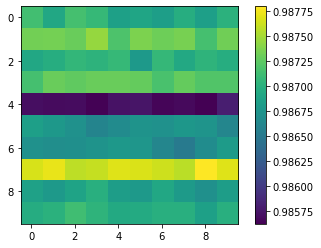

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(simmat_t_w)
plt.colorbar()
plt.show()